# Receiver comparison with an over the air connection


Any day now

In [1]:
from config import *
from OFDM_SDR_Functions_torch import *
import torch
from models_local import *
from OFDM_SDR_Functions_torch import *
from SDR_Pluto import *
import random

use_sdr = True

device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Display the selected device
print(device)

# Test tensor creation on the selected device
if device.type != "cpu":
    x = torch.ones(1, device=device)
    print(x)

device = "cpu" # Force CPU for now, trouble with converting complex tensors to mps

mps
tensor([1.], device='mps:0')


In [2]:
# for SDR
SDR_TX_Frequency = int(436e6) # SDR TX frequency
tx_gain_min = -50 # sdr tx max gain
tx_gain_max = 0 # sdr tx min gain
rx_gain = 0 # sdr rx gain


# in case SDR not available, for channel simulation
ch_SINR_min = 0 # channel emulation min SINR
ch_SINR_max = 50 # channel emulation max SINR

In [3]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False)
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)


Load the model and wights

In [4]:

model = RXModel(Qm).to(device)

# Load the model architecture and weights
checkpoint_path = 'data/rx_model_40.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RXModel(
  (input_conv): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (res_block_1): ResidualBlock(
    (layer_norm_1): LayerNorm((128, 14, 71), eps=1e-05, elementwise_affine=True)
    (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer_norm_2): LayerNorm((128, 14, 71), eps=1e-05, elementwise_affine=True)
    (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res_block_2): ResidualBlock(
    (layer_norm_1): LayerNorm((128, 14, 71), eps=1e-05, elementwise_affine=True)
    (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer_norm_2): LayerNorm((128, 14, 71), eps=1e-05, elementwise_affine=True)
    (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res_block_3): ResidualBlock(
    (layer_norm_1): LayerNorm((128, 14, 71), eps=1e-05, elementwise_affine=True)
    (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1

In [5]:
# start the SDR
if use_sdr: 
    SDR_1 = SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=SDR_TX_Frequency, SDR_TX_GAIN=-80, SDR_RX_GAIN = 0, SDR_TX_SAMPLERATE=SampleRate, SDR_TX_BANDWIDTH=F*SCS*2)
    SDR_1.SDR_TX_start()

In [6]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power)
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=False)
    TD_TTI_IQ = FFT(Modulated_TTI)
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP)
    zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype)
    TX_Samples = torch.cat((zeros, TX_Samples), dim=0)
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

In [7]:
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        SDR_1.SDR_gain_set(tx_gain, rx_gain)
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=1, cyclic=True)
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4)
        SDR_1.SDR_TX_stop()
    else:
        rx_signal  = generate_cdl_c_impulse_response(tx_signal = tx_signal, num_samples=16, sampling_rate=SampleRate, SINR=ch_SINR, repeats = 4, random_start=True)
    return rx_signal

In [8]:
# remove DC and FFT offsets from TTI mask_RE and add third dimension size of Qm, and expand TTI mask values into the third dimension
TTI_mask_RE_3d = TTI_mask_RE[:, FFT_offset:-FFT_offset]
middle_index = TTI_mask_RE_3d.size(1) // 2
TTI_mask_RE_3d = torch.cat((TTI_mask_RE_3d[:, :middle_index], TTI_mask_RE_3d[:, middle_index + 1:]), dim=1)
TTI_mask_RE_3d = TTI_mask_RE_3d.unsqueeze(-1).expand(S, F-1, Qm)

number_of_testcases = 200

SINR2BER_table = np.zeros((number_of_testcases,5))

for i in range(number_of_testcases):
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max))
    tx_gain_i = int(random.uniform(tx_gain_min, tx_gain_max))
    RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain_i, rx_gain = rx_gain, ch_SINR = ch_SINR)
    symbol_index=sync_TTI(TX_Samples, RX_Samples, leading_zeros)
    SINR_sig = SINR(RX_Samples, 100, symbol_index)
    RX_NO_CP = CP_removal(RX_Samples, symbol_index, S, FFT_size, CP, plotsig=False)
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP))
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False)

    ## NN-receiver
    # create pilot matrix as in the TTI mask
    z, pilot_symbols_map = get_pilot_symbols_raw(TTI_mask_RE, OFDM_demod) # get pilot symbols
    pilot_symbols_map = remove_fft_Offests(pilot_symbols_map, F, FFT_offset) # remove FFT offsets
    pilot_symbols_map = torch.cat((pilot_symbols_map[:, :F//2], pilot_symbols_map[:, F//2 + 1:]), dim=1).unsqueeze(0)# remove DC

    
    # create PDSCH matrix, the same shape
    z2, pdsch_symbols_map = get_payload_symbols_raw(TTI_mask_RE, OFDM_demod) # get PDSCH symbols
    pdsch_symbols_map = remove_fft_Offests(pdsch_symbols_map, F, FFT_offset) # remove FFT offsets
    pdsch_symbols_map = torch.cat((pdsch_symbols_map[:, :F//2], pdsch_symbols_map[:, F//2 + 1:]), dim=1).unsqueeze(0) # remove DC


    OFDM_NN = model((pdsch_symbols_map.to(device), pilot_symbols_map.to(device)))
    binary_predictions = torch.round(OFDM_NN)
    binary_predictions = torch.tensor(binary_predictions.squeeze()[TTI_mask_RE_3d==1].flatten().cpu(), dtype=torch.int8)

    # Calculate Bit Error Rate (BER) for the NN-receiver
    error_count = torch.sum(binary_predictions.flatten() != pdsch_bits.flatten()).float()  # Count of unequal bits
    error_rate = error_count / len(pdsch_bits.flatten())  # Error rate calculation
    BER_NN = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
    

    # LS/ZF receiver
    H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, OFDM_demod, plotEst=False)
    OFDM_demod_no_offsets = remove_fft_Offests(OFDM_demod, F, FFT_offset)
    equalized_H_estim = equalize_ZF(OFDM_demod_no_offsets, H_estim, F, S)
    QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=False)
    PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm)
    bits_est = PS(PS_est)
    error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
    error_rate = error_count / bits_est.numel()  # Error rate calculation
    BER_LSZF = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
    print("SINR: ", SINR_sig[0], " BER_NN: ", BER_NN, " BER_LSZF: ", BER_LSZF)
    # Save results
    SINR2BER_table[i,0] = round(tx_gain_i,1)
    SINR2BER_table[i,1] = round(rx_gain,1)
    SINR2BER_table[i,2] = round(SINR_sig[0],1)
    SINR2BER_table[i,3] = BER_LSZF
    SINR2BER_table[i,4] = BER_NN
    

/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_9482/860523608.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  binary_predictions = torch.tensor(binary_predictions.squeeze()[TTI_mask_RE_3d==1].flatten().cpu(), dtype=torch.int8)


SINR:  23.2  BER_NN:  tensor(0.0330)  BER_LSZF:  tensor(0.0180)
SINR:  31.8  BER_NN:  tensor(0.0280)  BER_LSZF:  tensor(0.0100)
SINR:  23.8  BER_NN:  tensor(0.0320)  BER_LSZF:  tensor(0.0160)
SINR:  9.9  BER_NN:  tensor(0.2250)  BER_LSZF:  tensor(0.2350)
SINR:  34.5  BER_NN:  tensor(0.0230)  BER_LSZF:  tensor(0.0040)
SINR:  15.5  BER_NN:  tensor(0.0910)  BER_LSZF:  tensor(0.0960)
SINR:  6.9  BER_NN:  tensor(0.2850)  BER_LSZF:  tensor(0.2920)
SINR:  1.4  BER_NN:  tensor(0.3840)  BER_LSZF:  tensor(0.4090)
SINR:  35.8  BER_NN:  tensor(0.0220)  BER_LSZF:  tensor(0.0030)
SINR:  33.9  BER_NN:  tensor(0.0220)  BER_LSZF:  tensor(0.0020)
SINR:  34.6  BER_NN:  tensor(0.0200)  BER_LSZF:  tensor(0.0010)
SINR:  32.5  BER_NN:  tensor(0.0210)  BER_LSZF:  tensor(0.)
SINR:  19.4  BER_NN:  tensor(0.0430)  BER_LSZF:  tensor(0.0240)
SINR:  6.5  BER_NN:  tensor(0.2600)  BER_LSZF:  tensor(0.2770)
SINR:  34.3  BER_NN:  tensor(0.0190)  BER_LSZF:  tensor(0.)
SINR:  35.4  BER_NN:  tensor(0.0190)  BER_LSZF:  ten

      txg  rxg  SINR  BER_LSZF  BER_NN
0   -21.0  0.0  23.2     0.018   0.033
1   -15.0  0.0  31.8     0.010   0.028
2   -20.0  0.0  23.8     0.016   0.032
3   -37.0  0.0   9.9     0.235   0.225
4    -6.0  0.0  34.5     0.004   0.023
..    ...  ...   ...       ...     ...
195  -2.0  0.0  36.5     0.000   0.015
196 -32.0  0.0  13.3     0.080   0.083
197 -24.0  0.0  22.9     0.000   0.020
198 -35.0  0.0  11.6     0.190   0.166
199 -24.0  0.0  22.9     0.002   0.020

[200 rows x 5 columns]


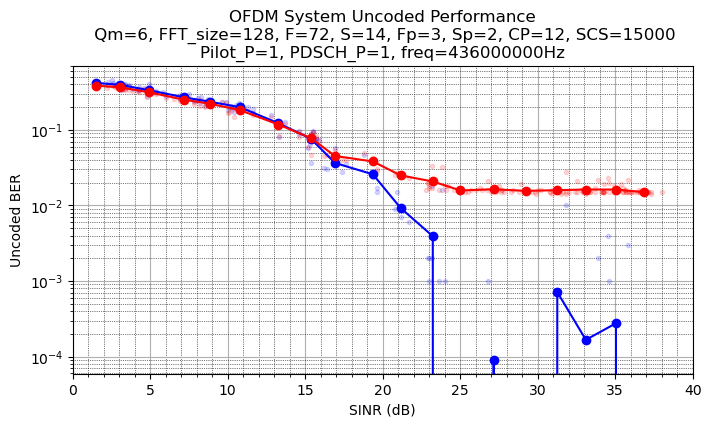

In [9]:
import pandas as pd

df = pd.DataFrame(SINR2BER_table, columns=['txg', 'rxg', 'SINR', 'BER_LSZF', 'BER_NN'])
print(df)
df['SINR_binned'] = pd.cut(df['SINR'], bins=range(-10, 40, 2), labels=range(-9, 39, 2))
df_grouped = df.groupby('SINR_binned', observed=False).mean()

plt.figure(figsize=(8, 4))
plt.plot(df['SINR'], df['BER_LSZF'], 'o', alpha=0.15, markersize=3, c='blue')
plt.plot(df['SINR'], df['BER_NN'], 'o', alpha=0.15, markersize=3, c='red')
plt.xlabel('SINR (dB)')
plt.ylabel('Uncoded BER')
plt.plot(df_grouped['SINR'], df_grouped['BER_LSZF'], '-o', color='blue')
plt.plot(df_grouped['SINR'], df_grouped['BER_NN'], '-o', color='red')

plt.title(f'OFDM System Uncoded Performance\n Qm={Qm}, FFT_size={FFT_size}, F={F}, S={S}, Fp={Fp}, Sp={Sp}, CP={CP}, SCS={SCS}\nPilot_P={Pilot_Power}, PDSCH_P={PDSCH_power}, freq={SDR_TX_Frequency}Hz')
plt.xlim(0, 40)
plt.yscale('log')
plt.grid()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
if save_plots:
    plt.savefig('pics/Performance.png')
plt.show()